<a href="https://colab.research.google.com/github/Pulkit-g03/ML-Task/blob/week8/Copy_of_Synapse_NLP_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SYNAPSE 2023-24 NLP Task 3**

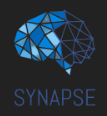






We have been exploring various Deep Learning techniques till now, and all of them somehow or the other through their shortcomings lead us to the architecture that shaped the future of NLP - the Transformer Model. Going further than its predecessor models, the Transformer architecture understands context in a way that other deep learning models like LSTM's and RNN's fail to do.

In this notebook, we will attempt to build a Transformer from scratch, particulary focusing on the Self Attention layer. A few things to note before we start:

1) This is not the **complete** and **latest** understanding of the Transformer architecture, implementing that is beyond the scope of any of us in this college as of now. This is an earlier iteration of the Attention Layer but is very much similar in its key concepts.

2) You might notice that not too many cells are given for you to complete in the Self Attention. This task is as much of understanding what is occuring in that code as it is a challenge to fill the blank sections of the code so that you don't feel overwhelmed but understand ki chal kya raha hai.

3) Don't fret if you feel overwhelmed by this, it IS difficult. Take your time, read up on resources and mainly focus on learning rather than just finishing off the task. Ok rant over

To get an idea of what we want to do and how we plan to get there, check these videos out: (StatQuest ftw):

Seq2Seq enc-dec neural networks - https://youtu.be/L8HKweZIOmg?si=lEqJj5RNRvuaOf-e

Attention in neural networks - https://youtu.be/PSs6nxngL6k?si=1NjFu2lyUhkVoIRW

Reviews.csv link download - https://drive.google.com/file/d/1T558yfJNALPogaILkbAvYO7C_P3qZEAT/view?usp=sharing

### Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Attention, Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.python.keras import backend as K
import gc
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Global Variables

These variables control key aspects of a language model for tasks like summarizing text. They set limits on input and output lengths (`max_len_text` and `max_len_summary`), determine how many times the model learns from the data (`epochs`), and specify the amount of data used (`number_of_datapoints`). The line `logger = tf.get_logger()` sets up a way to track the model's progress as it learns.

In [4]:
max_len_text=80
max_len_summary=10
epochs=10 ### PREFERABLY 50 must be done; for testing purposes use 10
number_of_datapoints=100000

logger = tf.get_logger()

Map contractions to their original phrase to make it easier to have a consistent representation of those terms and avoid mistakes in understanding context.

In [5]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
    "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as", "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

### Utility Data Preprocessing functions

In [6]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub(r'"', "''", newString)#Write regex to substitute occurences of double quotes(") with a blank space('')
    newString = ' '.join(contraction_mapping.get(word, word) for word in newString.split())#Split newString into words, contract them using contraction_mapping if needed and join back into a string
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [word for word in newString.split() if word.lower() not in set(stopwords.words('english'))]#return a list of words after removing stopwords
    long_words=[]
    for i in tokens:
      if len(i)>=3:
        long_words.append(i)
       #Append only if length of word >= 3

    return (" ".join(long_words)).strip()


In [7]:
def summary_cleaner(text):
    newString = re.sub(r'""',' ',text)#Write regex to substitute occurences of double quotes(") with a blank space('')
    newString = re.sub(r"\b\w+\b", lambda x: contraction_mapping.get(x.group(0), x.group(0)), newString)#Same contraction_mapping wala code
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

### Data Preprocessing

In [8]:
data=pd.read_csv("/content/gdrive/MyDrive/Reviews.csv",nrows=number_of_datapoints)

In [9]:
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!
99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu..."
99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s..."
99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra li..."


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99996 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99998 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [11]:
#Drop duplicate values from the Text column
data['Text'] =data['Text'].drop_duplicates(keep='first')
#Drop null values from the dataset
data.dropna(inplace=True)
data.reset_index(drop=True)
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!
99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu..."
99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s..."
99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra li..."


In [12]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [13]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
#Drop tuples in the data where there is a blank value ('') in data['cleaned_summary']


In [14]:
data['cleaned_summary'] = '_START_ ' + data['cleaned_summary'] + ' _END_'#Add a '_START_ ' and ' _END_' tag at the start and end of every data point of data['cleaned_summary']

In [15]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

### Analysis of Sentence and Summary Length

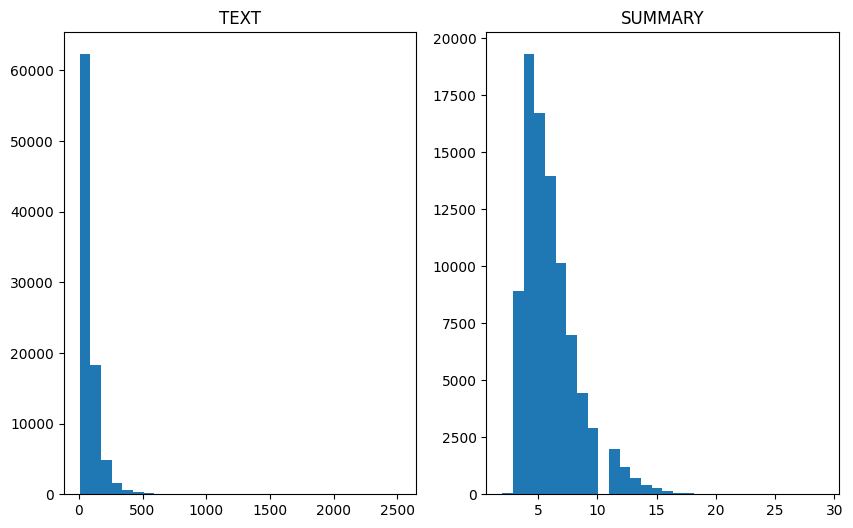

In [16]:
text_word_count = [data['Text'].apply(lambda x: len(str(x).split()))]
summary_word_count = [data['cleaned_summary'].apply(lambda x: len(str(x).split()))]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(text_word_count, bins=30)
plt.title('TEXT')

plt.subplot(1, 2, 2)
plt.hist(summary_word_count, bins=30)
plt.title('SUMMARY')

plt.show()

#Make 2 histograms depicting the word count in both Text and Summary columns


### Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [19]:
#Create an instance of Tokenizer() and fit it on x_tr
tokenizer= Tokenizer()
tokenizer.fit_on_texts(x_tr)

#convert text sequences into integer sequences for x_tr and x_val
int_x_tr=tokenizer.texts_to_sequences(x_tr)
int_x_val=tokenizer.texts_to_sequences(x_val)

#Add padding as you have done in the past
x_tr= pad_sequences(int_x_tr, maxlen=max_len_text, padding='post', truncating='post')
x_val= pad_sequences(int_x_val, maxlen=max_len_text, padding='post', truncating='post')
x_voc_size = len(tokenizer.word_index) + 1 #Number of words in vocabulary+1

In [20]:
x_voc_size

51931

In [21]:
#Create an instance of Tokenizer() and fit it on x_tr
tokenizer= Tokenizer()
tokenizer.fit_on_texts(y_tr)

#convert text sequences into integer sequences for x_tr and x_val
int_y_tr=tokenizer.texts_to_sequences(y_tr)
int_y_val=tokenizer.texts_to_sequences(y_val)

#Add padding as you have done in the past
y_tr= pad_sequences(int_y_tr, maxlen=max_len_text, padding='post', truncating='post')
y_val= pad_sequences(int_y_val, maxlen=max_len_text, padding='post', truncating='post')
y_voc_size = len(tokenizer.word_index) + 1

In [22]:
y_voc_size

14116

## Architecture

For the Attention Layer:
In Keras, it is easy to create a custom layer that implements attention by subclassing the Layer class. The Keras guide lists clear steps for creating a new layer via subclassing. You’ll use those guidelines here. All the weights and biases corresponding to a single layer are encapsulated by this class. You need to write the __init__ method as well as override the following methods:

build(): The Keras guide recommends adding weights in this method once the size of the inputs is known. This method “lazily” creates weights. The built-in function add_weight() can be used to add the weights and biases of the attention layer.

call(): The call() method implements the mapping of inputs to outputs. It should implement the forward pass during training.

Watch this videos to get an in-depth understanding - https://www.youtube.com/watch?v=fdhojC37_Co

https://www.youtube.com/watch?v=W2rWgXJBZhU

Read so that you understand and implement - https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/

And Read the research paper cited below!!!! :D

https://arxiv.org/abs/1706.03762 and the paper in the docstring of the function

Don't break this code cell into smaller parts, as the tf.keras.backend.clear_session() would not be able to properly clear the session

In [ ]:
tf.keras.backend.clear_session()

latent_dim = 500

# Encoder
encoder_inputs = #Input layer taking input size max_len_text
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = #Make LSTM layer with input latent_dim; ensure return_sequences and return_state is True because we want the layer to backpropagate
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Add 2 more LSTM layers like above


# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = #Similar to encoder layer embedding
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = #Similar to encoder LSTM layer
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        #inherit the parent class tf.keras.layers.Layer using the super keyword and include **kwargs in the argument

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        zeroth_index = # specify the zeroth tensor shape
        first_index = # specify the first tensor shape

        x = input_shape[zeroth_index][2]
        y = input_shape[first_index][2]

        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((y, x)),
                                   initializer='uniform'
                                   trainable=True)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((x, x)),
                                   initializer='uniform'
                                   trainable=True)

        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((x, 1)),
                                   initializer='uniform'
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = #Extract the final state from the states list

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = # Dot product of encoder_full_seq and W_a

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = #Extract the final state from the states list

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


# Attention Layer
attn_layer = #initialize object AttentionLayer and pass name parameter
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      25785500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

STATE YOUR UNDERSTANDING OF ATTENTION LAYER DESCRIPTIVELY :)

Write HEREEE -

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=epochs,batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
156/156 [==============================] - 160s 961ms/step - loss: 3.5974 - val_loss: 2.9873
Epoch 2/10
156/156 [==============================] - 145s 933ms/step - loss: 3.0694 - val_loss: 2.9631
Epoch 3/10
156/156 [==============================] - 150s 963ms/step - loss: 3.0147 - val_loss: 2.8803
Epoch 4/10
156/156 [==============================] - 151s 965ms/step - loss: 2.9510 - val_loss: 2.8318
Epoch 5/10
156/156 [==============================] - 145s 929ms/step - loss: 2.9329 - val_loss: 2.7789
Epoch 6/10
156/156 [==============================] - 145s 932ms/step - loss: 2.8528 - val_loss: 2.7606
Epoch 7/10
156/156 [==============================] - 145s 932ms/step - loss: 2.7911 - val_loss: 2.6861
Epoch 8/10
156/156 [==============================] - 145s 931ms/step - loss: 2.7487 - val_loss: 2.6579
Epoch 9/10
156/156 [==============================] - 150s 962ms/step - loss: 2.7080 - val_loss: 2.6376
Epoch 10/10
156/156 [==============================] - 146s 935m

In [ ]:
gc.collect()

1622

### Post Training Analysis & Testing

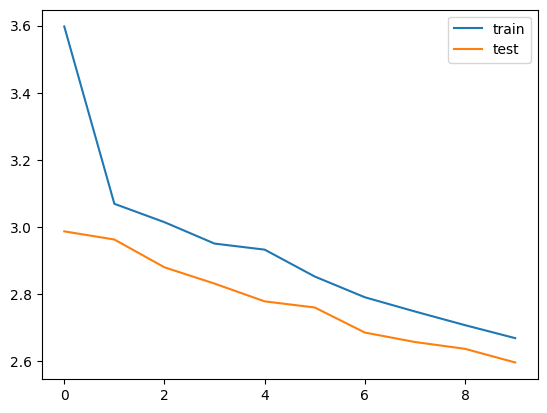

In [ ]:
#Plot loss and val_loss by extracting it from the history of the object


In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
#create a Model by specifying the inputs and the outputs (also consider h and c in output)
encoder_model =

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
#write a line similar for c

decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= #Use the decoder embedding layer you made above and pass decoder input to it

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = # create an attention layer with the help of decoder_hidden_state_input and decoder_outputs2
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary. Again, you have created this layer above, so use that
decoder_outputs2 =

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq =

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] =

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Write the code to predict the values of output_tokens, h, c based on our model

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index+1]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Write code for the Exit condition: either hit max length or find the 'end' word.
            if( ):
              stop_condition = True


        # Update the target sequence (of length 1).


        # Update internal states


    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    # write a code similar to that above, with some modifications in conditions


### Let's do some Generation

In [ ]:
i=1
print("Review:",seq2text(x_val[i]))
print("Original summary:",seq2summary(y_val[i]))
print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text))[:18])
print("\n")

Review: drank cold could pleased coffee high quality arabica always notice coffee arabica robusta sweet without sweet mean cannot compare major bottled coffee brand reason alone keep fridge work offer people without looking like pushing calories along caffeine long time would stock highly sweetened coffee beverages fridge work noticed people stopped consuming happened around time lost interest level sweetness recommend drink prefer lower level sugar old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 
1/1 [==============================] - 0s 48ms/step
Predicted summary:  the wonderful of 




End of task 4
--